#**Librerias y Funciones**

##**Librerias**

In [ ]:
# Importamos NumPy para operaciones numéricas
import numpy as np
# Importamos la biblioteca pandas y le asignamos el alias 'pd'
import pandas as pd
# Importamos Matplotlib y Seaborn para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
# Importamos SimpleImputer para el manejo de valores faltantes
from sklearn.impute import SimpleImputer
# Importamos StandardScaler para escalar características
from sklearn.preprocessing import StandardScaler
# Importamos SelectKBest y las funciones de puntuación de características f_classif
from sklearn.feature_selection import SelectKBest, f_classif
# Importamos imbalanced-learn para abordar problemas de clases desbalanceadas
!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
# Importamos el conjunto de datos de cáncer de mama de scikit-learn
from sklearn.datasets import load_breast_cancer

from sklearn.metrics import confusion_matrix, roc_auc_score

# Importamos la función train_test_split para dividir el conjunto de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [ ]:
from scipy import stats
from scipy.stats import pearsonr, spearmanr

##**funcion**

###**tipo_columna**

In [ ]:
import pandas as pd

def tipo_columna(df: pd.DataFrame, nombre: str, max_categoricos: int = 20) -> str:
    """
    Determina si una columna es continua, categórica o de fecha.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame que contiene la columna.
    nombre : str
        Nombre de la columna a analizar.
    max_categoricos : int, opcional
        Número máximo de valores únicos para considerar una variable numérica
        como categórica (por defecto 20).

    Devuelve:
    ---------
    str
        'Continuo' si es numérica con más de max_categoricos valores únicos,
        'Categórico' si es categórica u objeto, o numérica con pocos valores únicos,
        'Fecha' si es datetime.
    """
    if nombre not in df.columns:
        raise KeyError(f"No existe la columna '{nombre}' en el DataFrame.")

    s = df[nombre]
    # Columnas datetime
    if pd.api.types.is_datetime64_any_dtype(s):
        return 'Fecha'
    # Columnas numéricas
    if pd.api.types.is_numeric_dtype(s):
        n_unicos = s.nunique(dropna=False)
        return 'Categórico' if n_unicos <= max_categoricos else 'Continuo'
    # Columnas categóricas nativas o strings
    if pd.api.types.is_categorical_dtype(s) or pd.api.types.is_object_dtype(s):
        return 'Categórico'
    # Resto de tipos (bool, etc.)
    return 'Categórico'

###**interactive_hist_kde_select**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_hist_kde_select(df):
    """
    Muestra un panel interactivo para trazar automáticamente:
      - Histogramas + KDE de columnas numéricas seleccionadas.
      - Gráfico de barras si la columna seleccionada es 'target'.
    Permite controlar número de subplots, bins y tamaño de figura,
    sin necesidad de botón extra.
    """
    # Columnas disponibles
    cont_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) or c == 'target']
    if not cont_cols:
        raise ValueError("No hay columnas disponibles en el DataFrame.")

    # Widgets
    selector = widgets.SelectMultiple(
        options=cont_cols,
        description='Características:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )
    ncols_slider = widgets.IntSlider(
        value=3, min=1, max=6, step=1,
        description='Nº columnas:'
    )
    bins_slider = widgets.IntSlider(
        value=30, min=5, max=100, step=5,
        description='Bins:'
    )
    w_slider = widgets.FloatSlider(
        value=4.0, min=2.0, max=10.0, step=0.5,
        description='Ancho figura:'
    )
    h_slider = widgets.FloatSlider(
        value=3.2, min=1.0, max=6.0, step=0.2,
        description='Alto figura:'
    )
    output = widgets.Output()

    def _update(change):
        with output:
            clear_output(wait=True)
            cols = list(selector.value)
            if not cols:
                print("Selecciona al menos una columna.")
                return

            n_cols = ncols_slider.value
            bins = bins_slider.value
            fig_w, fig_h = w_slider.value, h_slider.value

            n_plots = len(cols)
            n_rows = int(np.ceil(n_plots / n_cols))
            fig, axes = plt.subplots(
                n_rows, n_cols,
                figsize=(n_cols * fig_w, n_rows * fig_h),
                constrained_layout=True
            )
            axes = axes.flatten()

            for ax, col in zip(axes, cols):
                if col == 'target':
                    counts = df[col].value_counts().sort_index()
                    counts.plot(kind='bar', ax=ax, color=['red','blue'], legend=False)
                    ax.set_xlabel(col)
                    ax.set_ylabel('Frecuencia')
                else:
                    df[col].plot.hist(
                        ax=ax, bins=bins, density=True,
                        alpha=0.6, edgecolor='k', linewidth=0.3, legend=False
                    )
                    df[col].plot.kde(ax=ax, legend=False)
                    ax.set_ylabel('Densidad', fontsize=8, color='gray')
                    ax.set_xlabel('')

                ax.set_title(col, fontsize=12, fontweight='bold')

            # Eliminar ejes sobrantes
            for ax in axes[n_plots:]:
                fig.delaxes(ax)

            plt.show()

    # Conectar todos los widgets para que actualicen automáticamente
    for w in (selector, ncols_slider, bins_slider, w_slider, h_slider):
        w.observe(_update, names='value')

    # Mostrar controles y área de gráfica
    display(widgets.VBox([
        selector,
        widgets.HBox([ncols_slider, bins_slider]),
        widgets.HBox([w_slider, h_slider]),
        output
    ]))

    # Gráfico inicial
    _update(None)


###**interactive_scatter_selector**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import ipywidgets as widgets
from IPython.display import display, clear_output

def plot_scatter_with_corr(df, col_x, col_y,
                           figsize=(6, 4),
                           point_size=18,
                           point_color='blue',
                           alpha=0.65,
                           title=None):
    x = df[col_x]; y = df[col_y]
    r_pear, _  = pearsonr(x, y)
    r_spear, _ = spearmanr(x, y)

    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(x, y, s=point_size, c=point_color, alpha=alpha, edgecolors='none')
    ax.text(0.98, 0.02,
            f"Pearson: {r_pear:.2f}\nSpearman: {r_spear:.2f}",
            transform=ax.transAxes, ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', fc='w', ec='gray', alpha=0.9),
            fontsize=9)
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    ax.set_title(title or f"{col_x} vs {col_y}")
    plt.tight_layout()
    plt.show()

def interactive_scatter_selector(df):
    cols = list(df.columns)
    x_sel = widgets.Dropdown(options=cols, description='Eje X:')
    y_sel = widgets.Dropdown(options=cols, description='Eje Y:')
    out   = widgets.Output()

    def update(_):
        with out:
            clear_output(wait=True)
            if x_sel.value == y_sel.value:
                print("❗ Selecciona dos ejes diferentes.")
            else:
                plot_scatter_with_corr(df, x_sel.value, y_sel.value)

    # Con observadores independientes, sin tocar nunca .options
    x_sel.observe(update, names='value')
    y_sel.observe(update, names='value')

    display(widgets.VBox([
        widgets.HBox([x_sel, y_sel]),
        out
    ]))




###**interactive_pairplot_no_class**

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_pairplot_no_class(df):
    """
    Permite seleccionar interactivamente múltiples características del DataFrame
    y dibujar un pairplot SIN separación de clases.
    Muestra un mensaje de 'Procesando datos...' al comenzar.
    """
    # Columnas numéricas disponibles (excluyendo 'target')
    cont_cols = [
        c for c in df.columns
        if np.issubdtype(df[c].dtype, np.number)
    ]
    if len(cont_cols) < 2:
        raise ValueError("Se requieren al menos dos columnas numéricas para el pairplot.")

    # Widgets interactivos
    selector = widgets.SelectMultiple(
        options=cont_cols,
        description='Características:',
        style={'description_width': 'initial'}
    )
    button = widgets.Button(description='Mostrar Pairplot', button_style='primary')
    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output(wait=True)
            print("Procesando datos para crear gráfico...")
            selected = list(selector.value)
            if len(selected) < 2:
                print("Selecciona al menos dos características.")
                return

            # Dibujar pairplot sin hue
            sns.pairplot(df[selected], plot_kws={'alpha': 0.6})
            plt.suptitle(
                "Relación entre características",
                y=1.02
            )
            plt.show()

    button.on_click(on_button_click)

    display(widgets.VBox([selector, button, output]))


###**interactive_ttest_stripplot**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_ttest_stripplot(df):
    """
    Muestra widgets para seleccionar columnas numéricas de df,
    t-test stripplots, con control de columnas, ancho y alto de figura.
    """
    df = df.copy()
    df['clase'] = df['target'].map({0: 'Maligno', 1: 'Benigno'})

    cont_cols = [
        col for col in df.columns
        if np.issubdtype(df[col].dtype, np.number) and col != 'target'
    ]
    if not cont_cols:
        raise ValueError("No se encontraron columnas numéricas para graficar.")

    # Widgets
    selector = widgets.SelectMultiple(
        options=cont_cols,
        description='Características:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )
    ncols_slider = widgets.IntSlider(
        value=2, min=1, max=6, step=1,
        description='Nº columnas:'
    )
    w_slider = widgets.FloatSlider(
        value=6.0, min=2.0, max=12.0, step=0.5,
        description='Ancho figura:'
    )
    h_slider = widgets.FloatSlider(
        value=4.0, min=2.0, max=8.0, step=0.2,
        description='Alto figura:'
    )

    output = widgets.Output()

    def _update(change):
        with output:
            clear_output(wait=True)
            selected = list(selector.value)
            if not selected:
                print("Selecciona al menos una variable.")
                return

            n_plots = len(selected)
            ncols = ncols_slider.value
            nrows = int(np.ceil(n_plots / ncols))
            fig_w = w_slider.value
            fig_h = h_slider.value

            fig, axes = plt.subplots(
                nrows, ncols,
                figsize=(ncols * fig_w, nrows * fig_h)
            )
            axes = np.array(axes).reshape(-1)

            for ax, col in zip(axes, selected):
                grupo_mal = df[df.target == 0][col]
                grupo_ben = df[df.target == 1][col]
                _, pval = stats.ttest_ind(grupo_ben, grupo_mal, equal_var=False)

                sns.stripplot(
                    x=col, y='clase', data=df,
                    jitter=0.2,
                    hue='clase',
                     palette={'Maligno':'red','Benigno':'blue'},
                    alpha=0.6,
                    legend=False,
                    ax=ax
                )
                ax.set_title(f'{col} ―t test - p_value = {pval:.4f}')
                ax.set_xlabel(col)
                ax.set_ylabel('')

            # Eliminar ejes sobrantes
            for ax in axes[n_plots:]:
                fig.delaxes(ax)

            plt.tight_layout()
            plt.show()

    # Observers
    for widget in (selector, ncols_slider, w_slider, h_slider):
        widget.observe(_update, names='value')

    # Display
    control_box = widgets.VBox([
        selector,
        widgets.HBox([ncols_slider, w_slider, h_slider])
    ])
    display(control_box, output)

    # Inicial
    selector.value = (cont_cols[0],)


###**interactive_gaussian_density**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_gaussian_density(df):
    """
    Muestra widgets para seleccionar variables numéricas de df,
    con control de número de columnas, ancho y alto de figura, y dibuja
    curvas de densidad gaussiana y puntos para cada clase.
    """
    if 'target' not in df.columns:
        raise ValueError("El DataFrame debe contener la columna 'target'.")
    df = df.copy()
    df['clase'] = df['target'].map({0: 'Maligno', 1: 'Benigno'})

    cont_cols = [
        col for col in df.columns
        if np.issubdtype(df[col].dtype, np.number) and col != 'target'
    ]
    if not cont_cols:
        raise ValueError("No se encontraron columnas numéricas para graficar.")

    # Widgets
    selector = widgets.SelectMultiple(
        options=cont_cols,
        description='Características:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )
    ncols_slider = widgets.IntSlider(
        value=1, min=1, max=6, step=1,
        description='Nº columnas:'
    )
    w_slider = widgets.FloatSlider(
        value=6.0, min=2.0, max=12.0, step=0.5,
        description='Ancho figura:'
    )
    h_slider = widgets.FloatSlider(
        value=4.0, min=2.0, max=8.0, step=0.2,
        description='Alto figura:'
    )

    output = widgets.Output()

    def _update(change):
        with output:
            clear_output(wait=True)
            selected = list(selector.value)
            if not selected:
                print("Selecciona al menos una variable.")
                return

            n_plots = len(selected)
            ncols = ncols_slider.value
            nrows = int(np.ceil(n_plots / ncols))
            fig_w = w_slider.value
            fig_h = h_slider.value

            fig, axes = plt.subplots(
                nrows, ncols,
                figsize=(ncols * fig_w, nrows * fig_h)
            )
            axes = np.array(axes).reshape(-1)

            for ax, col in zip(axes, selected):
                w_mal = df.loc[df.clase == 'Maligno', col]
                w_ben = df.loc[df.clase == 'Benigno', col]
                mu_mal, std_mal = w_mal.mean(), w_mal.std(ddof=0)
                mu_ben, std_ben = w_ben.mean(), w_ben.std(ddof=0)

                x = np.linspace(df[col].min() - 1, df[col].max() + 1, 500)
                pdf_mal = stats.norm.pdf(x, mu_mal, std_mal)
                pdf_ben = stats.norm.pdf(x, mu_ben, std_ben)

                ax.plot(x, pdf_mal, label='Maligno', color='red', linewidth=2)
                ax.plot(x, pdf_ben, label='Benigno', color='blue', linewidth=2)
                ax.scatter(w_mal, np.zeros_like(w_mal), marker='|', color='red', alpha=0.4)
                ax.scatter(w_ben, np.zeros_like(w_ben), marker='|', color='blue', alpha=0.4)

                ax.set_title(f'{col} ― Densidad Gaussiana')
                ax.set_xlabel(col)
                ax.set_ylabel('Densidad')
                ax.legend()

            for ax in axes[n_plots:]:
                fig.delaxes(ax)

            plt.tight_layout()
            plt.show()

    for w in (selector, ncols_slider, w_slider, h_slider):
        w.observe(_update, names='value')

    control_box = widgets.VBox([
        selector,
        widgets.HBox([ncols_slider, w_slider, h_slider])
    ])
    display(control_box, output)

    # Inicial
    selector.value = (cont_cols[0],)


###**visualizador_regresion_lineal_simple**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def visualizador_regresion_lineal_simple(df):
    """
    - Selecciona X, Y y cuántos puntos usar.
    - Imprime cálculo manual de w₀, w₁.
    - Dibuja el scatter y la recta usando w₀_man y w₁_man.
    - Leyenda fuera y recuadro con W₁/W₀.
    """
    # Columnas numéricas
    cont_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    total = len(df)
    if len(cont_cols) < 2:
        raise ValueError("Se requieren al menos dos columnas numéricas.")

    # Widgets
    x_sel    = widgets.Dropdown(options=cont_cols, description='Variable X:')
    y_sel    = widgets.Dropdown(options=cont_cols, description='Variable Y:')
    n_slider = widgets.IntSlider(value=2, min=2, max=total, step=1,
                                 description='Total datos:')

    # Inicializa X en el primero y Y en el segundo
    x_sel.value = cont_cols[0]
    y_sel.value = cont_cols[1]  # el segundo elemento

    out      = widgets.Output()

    def update(_):
        with out:
            clear_output(wait=True)
            # 1) Toma los primeros N puntos
            X = df[x_sel.value].values[:n_slider.value]
            Y = df[y_sel.value].values[:n_slider.value]
            n = len(X)

            # 2) Cálculo manual de w1_man, w0_man
            x̄      = X.mean()
            ȳ      = Y.mean()
            cov_xy = ((X - x̄)*(Y - ȳ)).sum()
            var_x  = ((X - x̄)**2).sum()
            w1_man = cov_xy / var_x
            w0_man = ȳ - w1_man * x̄

            # 3) Imprime paso a paso
            print("CÁLCULO PASO A PASO DE LA RECTA DE REGRESIÓN")
            print("-"*50)
            print(f"n        = {n}")
            print(f"x̄        = ∑xᵢ / n        = {x̄:.4f}")
            print(f"ȳ        = ∑yᵢ / n        = {ȳ:.4f}")
            print(f"Cov(x,y) = ∑(xᵢ−x̄)(yᵢ−ȳ)  = {cov_xy:.4f}")
            print(f"Var(x)   = ∑(xᵢ−x̄)²      = {var_x:.4f}")
            print(f"w₁(man)  = Cov/Var        = {cov_xy:.4f} / {var_x:.4f} = {w1_man:.4f}")
            print(f"w₀(man)  = ȳ − w₁·x̄      = {ȳ:.4f} − {w1_man:.4f}·{x̄:.4f} = {w0_man:.4f}")
            print("-"*50 + "\n")

            # 4) Dibujo del scatter + recta manual
            fig, ax = plt.subplots(figsize=(12,6))
            ax.scatter(X, Y, s=30, alpha=0.6, edgecolors='none')

            # línea de regresión manual desde x=0 hasta max(X)
            x_line = np.linspace(0, X.max(), 100)
            y_line = w0_man + w1_man * x_line
            ax.plot(x_line, y_line, color='red', lw=2,
                    label=f"y={w1_man:.2f}x+{w0_man:.2f}")

            # Leyenda fuera
            ax.legend(loc='upper left',
                      bbox_to_anchor=(1.02, 1),
                      title=f"Recta",
                      borderaxespad=0.)

            # Recuadro con W1/W0
            ax.text(1.03, 0.6,
                    f"Parametros:\nW₁ = {w1_man:.2f}\nW₀ = {w0_man:.2f}",
                    transform=ax.transAxes,
                    fontsize=14,
                    verticalalignment='top',
                    bbox=dict(facecolor='white', edgecolor='gray',
                              boxstyle='round,pad=0.3'))

            ax.set_xlim(left=0)
            ax.set_xlabel(x_sel.value)
            ax.set_ylabel(y_sel.value)
            ax.set_title(f"Regresión lineal simple ({n} datos)")
            plt.tight_layout(rect=[0, 0, 0.85, 1])
            plt.show()

    # Conecta widgets
    for w in (x_sel, y_sel, n_slider):
        w.observe(update, names='value')

    display(widgets.VBox([
        widgets.HBox([x_sel, y_sel]),
        n_slider,
        out
    ]))
    update(None)



###**visualizador_regresion_lineal_MSE**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets

def print_regression_math(df_x, df_y):
    x = df_x; y = df_y
    n = len(y)
    x_mean = x.mean()
    y_mean = y.mean()
    cov_xy = ((x - x_mean)*(y - y_mean)).sum()
    var_x  = ((x - x_mean)**2).sum()
    w1 = cov_xy/var_x
    w0 = y_mean - w1*x_mean

    print("CÁLCULO PASO A PASO DE LA RECTA DE REGRESIÓN (entrenamiento)")
    print("."*60)
    print(f"n        = {n}")
    print(f"x̄        = ∑xᵢ / n        = {x_mean:.4f}")
    print(f"ȳ        = ∑yᵢ / n        = {y_mean:.4f}")
    print(f"Cov(x,y) = ∑(xᵢ−x̄)(yᵢ−ȳ)  = {cov_xy:.4f}")
    print(f"Var(x)   = ∑(xᵢ−x̄)²      = {var_x:.4f}")
    print(f"w₁       = Cov/Var        = {cov_xy:.4f} / {var_x:.4f} = {w1:.4f}")
    print(f"w₀       = ȳ − w₁·x̄      = {y_mean:.4f} − {w1:.4f}·{x_mean:.4f} = {w0:.4f}")
    print("_"*60 + "\n")
    return w0, w1

def visualizador_regresion_lineal_MSE(df):
    cont_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    total = len(df)
    if len(cont_cols) < 2:
        raise ValueError("Se requieren al menos dos variables numéricas.")

    # Widgets
    n_slider   = widgets.IntSlider(value=100, min=2, max=total,
                                   description='Total datos:')
    pct_slider = widgets.IntSlider(value=100, min=0, max=100,
                                   description='% Datos de entrenamiento:')
    x_sel = widgets.Dropdown(options=cont_cols, description='Variable X:')
    y_sel = widgets.Dropdown(options=cont_cols, description='Variable Y:')
    # Inicializa X en el primero y Y en el segundo
    x_sel.value = cont_cols[0]
    y_sel.value = cont_cols[1]  # el segundo elemento

    out   = widgets.Output()

    def _update(_):
        with out:
            clear_output(wait=True)
            # Preparar datos
            X = df[x_sel.value].values[:n_slider.value]
            Y = df[y_sel.value].values[:n_slider.value]
            idx = np.arange(len(X))
            np.random.seed(42); np.random.shuffle(idx)
            n_train = int(len(X)*(pct_slider.value/100))
            X_train, Y_train = X[idx][:n_train], Y[idx][:n_train]
            X_test,  Y_test  = X[idx][n_train:], Y[idx][n_train:]

            # Cálculo entrenamiento
            w0, w1 = print_regression_math(X_train, Y_train)

            # ——— CÁLCULO DE PREDICCIÓN EN TEST ———
            if len(X_test):
                # Mostrar fórmulas
                print("CÁLCULO DE PREDICCIÓN EN TEST")
                print("Fórmulas utilizadas:")
                print(f"  ŷᵢ = w₁·xᵢ + w₀        → ŷᵢ = {w1:.4f}·xᵢ + {w0:.4f}")
                print("  errorᵢ = (yᵢ - ŷᵢ)²")
                print("  MSE = (1/N)·∑ errorᵢ")
                print("."*60)
                print()
                # Cálculos concretos
                y_pred = w1*X_test + w0
                errors = (Y_test - y_pred)**2
                mse = errors.mean()
                # Desglose por punto
                for i,(xi, yi, yhat, e) in enumerate(zip(X_test, Y_test, y_pred, errors),1):
                    print(f"{i:2d}) x={xi:.4f} → ŷ={yhat:.4f}    y={yi:.4f}    error²={e:.4f}")
                print(f"\nMSE = ∑error²/{len(X_test)} = {mse:.4f}")
                print("-"*60 + "\n")
            else:
                mse = 0.0

            # Gráfico con línea manual
            fig, ax = plt.subplots(figsize=(12,6))
            ax.scatter(X_train, Y_train, color='blue', alpha=0.3, label='Entrenamiento')
            if len(X_test):
                ax.scatter(X_test, Y_test, color='orange', alpha=0.3, marker='o', label='Valor real')
                # Añadir punto verde intermedio si hay entre 1 y 5 tests
                if 1 <= len(X_test) <= 5:
                    y_pred = w1*X_test + w0
                    ax.scatter(X_test, y_pred, color='green', s=60,
                               label='Valor predicho')
            x_line = np.linspace(0, X.max(), 100)
            y_line = w0 + w1*x_line
            ax.plot(x_line, y_line, color='red', lw=2, label=f"y={w1:.2f}x+{w0:.2f}")

            legend_title = f"Datos de entrenamiento: {n_train}\nDatos de prueba: {len(X_test)}"
            ax.legend(title=legend_title, loc='upper left', bbox_to_anchor=(1.02,1))
            ax.text(1.03, 0.6, f"W₁ = {w1:.2f}\nW₀ = {w0:.2f}",
                    transform=ax.transAxes, fontsize=16, verticalalignment='top',
                    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

            # Texto adicional debajo con el MSE
            ax.text(1.03, 0.44,  # un poco más abajo (ajusta si es necesario)
            f"MSE = {mse:.2f}",
            transform=ax.transAxes, fontsize=14, verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

            ax.set_xlim(left=0)
            ax.set_xlabel(x_sel.value)
            ax.set_ylabel(y_sel.value)
            ax.set_title(f"Regresión con {n_train} train / {len(X_test)} test de {len(X)} datos")
            plt.tight_layout(rect=[0,0,0.85,1])
            plt.show()

    # Observers
    for w in (x_sel, y_sel, n_slider, pct_slider):
        w.observe(_update, names='value')

    display(widgets.VBox([
        widgets.HBox([x_sel, y_sel]),
        n_slider, pct_slider, out
    ]))
    _update(None)




###**visualizador_clasificador_univariable**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

def Clasificador_univariable(X_train, y_train, activation_fn='logistic'):
    """
    Ajusta un 'perceptrón' con activación seleccionable
    (MLP de una sola neurona) y muestra coeficiente e intercepto.
    X_train: array 1D
    y_train: labels 0/1
    activation_fn: 'identity', 'logistic', 'tanh', 'relu'
    Returns:
      model: MLPClassifier
      w0, w1: intercepto y coeficiente
    """
    Xr = X_train.reshape(-1, 1)
    model = MLPClassifier(
        hidden_layer_sizes=(),      # sin capas ocultas → una sola neurona
        activation=activation_fn,   # activación seleccionable
        solver='lbfgs',             # optimizador determinista
        max_iter=1000,
    )
    model.fit(Xr, y_train)

    # Extraer pesos: coefs_[0] es (n_features, n_outputs)
    w1 = model.coefs_[0][0][0]
    # intercepts_[0] es (n_outputs,)
    w0 = model.intercepts_[0][0]

    n = len(y_train)
    c0 = int((y_train == 0).sum())
    c1 = int((y_train == 1).sum())

      # Mapa de fórmulas de activación
    formulas = {
        'identity': 'g(Z) = Z',
        'logistic': 'g(Z) = 1/(1 + exp(-Z))',
        'tanh':     'g(Z) = tanh(Z)',
        'relu':     'g(Z) = max(0, Z)'
    }
    print()
    print("-" * 60)
    print("CÁLCULO PASO A PASO DEL CLASIFICADOR")
    print(f"n                   = {n}")
    print(f"Clases              = 0: {c0}  |  1: {c1}")
    print(f"Intercept (w₀)      = {w0:.4f}")
    print(f"Coeficiente (w₁)    = {w1:.4f}")
    print(f"Z (w₁·X + w₀)       = {w1:.4f}·X + {w0:.4f}")
     # Impresión del nombre de la función y su fórmula
    print(f"Función activación  = {activation_fn}  |  {formulas.get(activation_fn, '')}")
    print("-" * 60)
    print()

    return model, w0, w1


def visualizador_clasificador_univariable(df):
    """
    Visualiza un perceptrón entrenado sobre un solo feature.
    - Selección de columna numérica X
    - Target binario en 'target'
    - Split estratificado, coeficientes, predicción y métricas, incluyendo ROC AUC
    """
    # Columnas numéricas (X) y verificación de 'target'
    cont_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number) and c != 'target']
    total = len(df)
    if 'target' not in df.columns:
        raise ValueError("El DataFrame debe contener la columna 'target'.")
    if len(cont_cols) < 1:
        raise ValueError("Se requiere al menos una variable numérica para X.")

    # Widgets
    activation_sel = widgets.Dropdown(
        options=['identity', 'logistic', 'tanh', 'relu'],
        value='logistic',
        description='Función activación:'
    )
    x_sel      = widgets.Dropdown(options=cont_cols, description='Variable X:')
    x_sel.value = cont_cols[0]
    n_slider   = widgets.IntSlider(value=100, min=2, max=total, description='Total datos:')
    pct_slider = widgets.IntSlider(value=98, min=1, max=99, description='% Entrenamiento:')
    out        = widgets.Output()

    def _update(_):
        with out:
            clear_output(wait=True)

            # Preparar datos
            X_full = df[x_sel.value].values[:n_slider.value]
            Y_full = df['target'].values[:n_slider.value]

            # Split estratificado
            pct_train = pct_slider.value / 100
            try:
                X_train, X_test, Y_train, Y_test = train_test_split(
                    X_full, Y_full,
                    train_size=pct_train,
                    random_state=42,
                    stratify=Y_full
                )
            except ValueError as e:
                print("⚠️ No se pudo estratificar:", e)
                return

            # Aplanar
            X_train = X_train.ravel()
            X_test  = X_test.ravel()
            Y_train = Y_train.ravel()
            Y_test  = Y_test.ravel()

            # Entrenar Clasificador con activación seleccionada
            activation_fn = activation_sel.value
            model, w0, w1 = Clasificador_univariable(X_train, Y_train, activation_fn)

            # Evaluación en test con cálculo manual
            if len(X_test):
                # z, p, yhat
                z_test     = w1 * X_test + w0
                p_test = model.predict_proba(X_test.reshape(-1,1))[:,1]
                yhat_test  = model.predict(X_test.reshape(-1,1))

                # 3) Cálculo manual de métricas
                TP = np.sum((yhat_test == 1) & (Y_test == 1))
                TN = np.sum((yhat_test == 0) & (Y_test == 0))
                FP = np.sum((yhat_test == 1) & (Y_test == 0))
                FN = np.sum((yhat_test == 0) & (Y_test == 1))

                accuracy  = (TP + TN) / len(Y_test)
                specificity= TN / (TN + FP) if (TN + FP)>0 else 0.0  # Especificidad
                sensitivity= TP / (TP + FN) if (TP + FN)>0 else 0.0  # Sensibilidad
                # Cálculo ROC AUC usando probabilidades
                try:
                    roc_auc = roc_auc_score(Y_test, p_test)
                except ValueError:
                    roc_auc = float('nan')

                cm = np.array([[TN, FP],
                               [FN, TP]])

               # Impresión de métricas paso a paso con límite y anotación final
                print()
                print("-" * 60)
                print("CÁLCULO DE PREDICCIÓN")

                max_print = 5
                last_i = None
                last_values = None
                for i, (xi, yi, zi, pi, ci) in enumerate(zip(X_test, Y_test, z_test, p_test, yhat_test), 1):
                    if i <= max_print:
                        print(f"{i:2d}) x={xi:.4f} → z={zi:.4f} → g(z)={pi:.4f} → ŷ={ci} (real={yi})")
                        last_i = i
                        last_values = (xi, yi, zi, pi, ci)
                    else:
                        print("...")
                        break
                if last_i != len(X_test):
                    # Imprimir última fila
                    print(f"{len(X_test)}): x={last_values[0]:.4f} → z={last_values[2]:.4f} → g(z)={last_values[3]:.4f} → ŷ={last_values[4]} (real={last_values[1]})")
                print("-" * 60 + "\n")
                # --- resto del bloque de clasificación: curva y puntos ---
                print()
                print("-" * 135 + "\n")
                fig, ax = plt.subplots(figsize=(11.35,5))
                ax.scatter(X_train, Y_train, alpha=0.3, label='Entrenamiento')
                if 1 <= len(X_test) <= 12:
                    ax.scatter(X_test, Y_test, marker='o', alpha=0.8, label='Valor real')
                    ax.scatter(X_test, yhat_test, marker='x', alpha=0.6, label='Valor predicho')
                x_line = np.linspace(X_full.min(), X_full.max(), 200)
                y_line = model.predict_proba(x_line.reshape(-1,1))[:,1]
                ax.plot(x_line, y_line, 'r--', lw=2, label=f'Activación: {activation_fn}')
                ax.set_xlabel(x_sel.value)
                ax.set_ylabel('Naturaleza del Tumor')
                ax.set_yticks([0,1])
                ax.set_yticklabels(['Maligno','Benigno'])
                title = f"{len(X_train)} train / {len(X_test)} test de {len(X_full)} datos"
                ax.set_title(f"Clasificador — {title}")
                ax.legend(loc='best')
                plt.tight_layout()
                plt.show()
                print("-" * 135 + "\n")

                print("\n" + "-" * 60)
                print("MÉTRICAS")
                print(f"Accuracy    = (TP+TN)/N        = ({TP}+{TN})/{len(Y_test)} = {accuracy:.4f}")
                print(f"Specificity = TN/(TN+FP)     = {TN}/({TN}+{FP}) = {specificity:.4f}")
                print(f"Sensitivity = TP/(TP+FN)     = {TP}/({TP}+{FN}) = {sensitivity:.4f}")
                print(f"ROC AUC     = {roc_auc:.4f}")
                print("-" * 60 + "\n")

               # Subplots: Matriz de Confusión y Curva ROC
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

                # Matriz de confusión
                cax = ax1.matshow(cm, cmap=plt.cm.Blues)
                ax1.set_xticks([0,1]); ax1.set_yticks([0,1])
                ax1.set_xticklabels(['Pred 0','Pred 1']); ax1.set_yticklabels(['True 0','True 1'])
                labels = [['TN','FP'],['FN','TP']]
                for ii in range(2):
                    for jj in range(2):
                        ax1.text(jj, ii, f"{labels[ii][jj]}={cm[ii][jj]}", va='center', ha='center',
                                 color='white' if cm[ii][jj]>cm.max()/2 else 'black')
                ax1.set_xlabel('Predicción'); ax1.set_ylabel('Etiqueta real')
                ax1.set_title('Matriz de Confusión')

                # Curva ROC
                fpr, tpr, _ = roc_curve(Y_test, p_test)
                ax2.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
                ax2.plot([0,1], [0,1], 'k--', label='Aleatorio')
                ax2.set_xlabel('False Positive Rate')
                ax2.set_ylabel('True Positive Rate')
                ax2.set_title('Curva ROC')
                ax2.legend(loc='lower right')

                plt.tight_layout()
                print()
                print("-" * 135)
                plt.show()
                print()
                print("-" * 135 + "\n")

            else:
                yhat_test = np.array([])



        # Conectar observadores
    for w in (activation_sel, x_sel, n_slider, pct_slider):
        w.observe(_update, names='value')
    display(widgets.VBox([activation_sel, x_sel, n_slider, pct_slider, out]))
    _update(None)


###**interactive_multidim_selector**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from IPython.display import display, clear_output
import ipywidgets as widgets

def interactive_multidim_selector(df):
    """
    Selector interactivo para 1-3 variables:
      • 1D: densidad univariante + puntos
      • 2D: scatter 2D + regiones logísticas
      • 3D: scatter 3D + plano de decisión logística interactivo con el ratón
    """
    cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number) and c != 'target']
    if not cols:
        raise ValueError("No se encontraron columnas numéricas.")

    # UI Widgets
    count_selector = widgets.Dropdown(options=[1,2,3], description='N° Características:')
    feat1 = widgets.Dropdown(options=cols, description='Característica 1:')
    feat2 = widgets.Dropdown(options=cols, description='Característica 2:')
    feat3 = widgets.Dropdown(options=cols, description='Característica 3:')
    button = widgets.Button(description='Mostrar Gráfico', button_style='primary')
    output = widgets.Output()

    # Mostrar/Ocultar dropdowns según selección
    def update_selectors(change):
        k = count_selector.value
        # 1) Mostrar/ocultar dropdowns
        feat1.layout.display = 'block'
        feat2.layout.display = 'block' if k>=2 else 'none'
        feat3.layout.display = 'block' if k>=3 else 'none'
        # 2) Bloquear en feat2 la opción seleccionada en feat1
        feat2.options = [c for c in cols if c != feat1.value]
        # 3) Bloquear en feat3 las opciones de feat1 y feat2
        feat3.options = [c for c in cols if c not in (feat1.value, feat2.value)]
    count_selector.observe(update_selectors, names='value')
    feat1.observe(update_selectors, names='value')   # para que feat2 se actualice al cambiar feat1
    feat2.observe(update_selectors, names='value')   # para que feat3 se actualice al cambiar feat2
    update_selectors(None)  # inicializar opciones


    # Generar gráfico al pulsar botón
    def on_button_click(_):
        with output:
            clear_output(wait=True)
            k = count_selector.value
            selected = [feat1.value]
            if k>=2: selected.append(feat2.value)
            if k>=3: selected.append(feat3.value)

            data = df[selected+['target']].dropna().copy()
            data['clase'] = data['target'].map({0:'Maligno',1:'Benigno'})

            # 1D
            if k==1:
                col = selected[0]
                x = np.linspace(data[col].min()-1, data[col].max()+1, 500)
                fig, ax = plt.subplots(figsize=(14,6))
                for cls,color in [('Maligno','red'),('Benigno','blue')]:
                    samp = data.loc[data.clase==cls, col]
                    mu,std = samp.mean(), samp.std(ddof=0)
                    ax.plot(x, norm.pdf(x, mu, std), color=color, lw=2, label=cls)
                    ax.scatter(samp, np.zeros_like(samp), marker='|', c=color, alpha=0.4)
                ax.set_xlabel(col); ax.set_ylabel('Densidad')
                ax.set_title(f"Densidad univariante: {col}")
                ax.legend()
                plt.show()

            # 2D
            elif k==2:
                xcol,ycol = selected
                # Clasificador logístico
                Xc = data[[xcol,ycol]].values
                yc = (data['clase']=='Benigno').astype(int).values
                log = LogisticRegression(solver='liblinear').fit(Xc,yc)
                xx = np.linspace(data[xcol].min()-1, data[xcol].max()+1, 200)
                yy = np.linspace(data[ycol].min()-1, data[ycol].max()+1, 200)
                Xg,Yg = np.meshgrid(xx,yy)
                Z = log.predict(np.c_[Xg.ravel(),Yg.ravel()]).reshape(Xg.shape)

                fig, ax = plt.subplots(figsize=(14,6))
                ax.contourf(Xg, Yg, Z, alpha=0.2, levels=[-0.5,0.5,1.5], colors=['red','blue'])
                for cls,color in [('Maligno','red'),('Benigno','blue')]:
                    pts = data.loc[data.clase==cls, [xcol,ycol]].values
                    ax.scatter(pts[:,0], pts[:,1], c=color, label=cls, alpha=0.6, edgecolors='none')
                ax.set_xlabel(xcol); ax.set_ylabel(ycol)
                ax.set_title("Separación de clases 2D")
                ax.legend(loc='upper right')
                plt.show()

            # 3D
            else:
                xcol,ycol,zcol = selected
                # Clasificador logístico 3D
                Xc = data[[xcol,ycol,zcol]].values
                yc = (data['clase']=='Benigno').astype(int).values
                log = LogisticRegression(solver='liblinear').fit(Xc,yc)
                w = log.coef_[0]; b = log.intercept_[0]

                # Crear malla para el plano de decisión
                xx = np.linspace(data[xcol].min(), data[xcol].max(), 10)
                yy = np.linspace(data[ycol].min(), data[ycol].max(), 10)
                XX,YY = np.meshgrid(xx,yy)
                ZZ = -(w[0]*XX + w[1]*YY + b)/w[2]

                # Plot 3D interactivo
                fig = plt.figure(figsize=(14,6))
                ax = fig.add_subplot(111, projection='3d')
                for cls,color in [('Maligno','red'),('Benigno','blue')]:
                    pts = data.loc[data.clase==cls, [xcol,ycol,zcol]].values
                    ax.scatter(pts[:,0], pts[:,1], pts[:,2], c=color, label=cls, alpha=0.6)
                ax.plot_surface(XX,YY,ZZ, alpha=0.3, color='gray')

                ax.set_xlabel(xcol); ax.set_ylabel(ycol); ax.set_zlabel(zcol)
                ax.set_title("Separación de clases 3D")
                ax.legend(loc='upper left', bbox_to_anchor=(1.02,1))

                # Nota: asegúrate de usar el backend interactivo (%matplotlib widget)
                plt.tight_layout()
                plt.show()

    button.on_click(on_button_click)
    display(widgets.VBox([count_selector, feat1, feat2, feat3, button, output]))



###**interactive_3d_scatter_rotatable**

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from IPython.display import display, clear_output
import ipywidgets as widgets

def interactive_3d_scatter_rotatable(df):
    """
    Visualizador 3D interactivo de tres variables:
      • Scatter 3D de las dos clases (Maligno/Benigno)
      • Sin plano de separación
      • Rotación manual con sliders (azimut/elevación)
    """
    # Columnas numéricas disponibles (excluyendo 'target')
    cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number) and c != 'target']
    if len(cols) < 3:
        raise ValueError("Se requieren al menos tres columnas numéricas.")

    # Widgets para ejes y rotación
    x_sel     = widgets.Dropdown(options=cols, description='Eje X:')
    y_sel     = widgets.Dropdown(options=cols, description='Eje Y:')
    z_sel     = widgets.Dropdown(options=cols, description='Eje Z:')
    az_slider = widgets.IntSlider(value=45, min=0, max=360, step=5, description='Azimut:')
    el_slider = widgets.IntSlider(value=30, min=0, max=90,  step=5, description='Elevación:')
    button    = widgets.Button(description='Mostrar 3D', button_style='primary')
    output    = widgets.Output()

    def plot_3d(_):
        with output:
            clear_output(wait=True)
            xcol, ycol, zcol = x_sel.value, y_sel.value, z_sel.value
            df_sub = df[[xcol, ycol, zcol, 'target']].dropna().copy()
            df_sub['clase'] = df_sub['target'].map({0: 'Maligno', 1: 'Benigno'})

            # Dibujar scatter 3D de las dos clases
            fig = plt.figure(figsize=(12, 6))
            ax  = fig.add_subplot(111, projection='3d')
            for cls, color in [('Maligno', 'red'), ('Benigno', 'blue')]:
                pts = df_sub[df_sub.clase == cls][[xcol, ycol, zcol]].values
                ax.scatter(
                    pts[:, 0], pts[:, 1], pts[:, 2],
                    c=color, label=cls, alpha=0.6
                )

            # Aplicar rotación inicial de acuerdo a sliders
            ax.view_init(elev=el_slider.value, azim=az_slider.value)

            ax.set_xlabel(xcol)
            ax.set_ylabel(ycol)
            ax.set_zlabel(zcol)
            ax.set_title('Dispersión 3D de clases')
            ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
            plt.tight_layout()
            plt.show()

    # Enlazar eventos
    button.on_click(plot_3d)
    az_slider.observe(plot_3d, names='value')
    el_slider.observe(plot_3d, names='value')

    # Mostrar UI
    display(widgets.VBox([
        widgets.HBox([x_sel, y_sel, z_sel]),
        widgets.HBox([az_slider, el_slider]),
        button,
        output
    ]))


###**interactive_pairplot**

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_pairplot(df):
    """
    Permite seleccionar interactivamente múltiples características del DataFrame
    y dibujar un pairplot coloreado por 'clase' (Maligno/Benigno).
    """
    # Columnas numéricas disponibles (excluyendo 'target')
    cont_cols = [
        c for c in df.columns
        if np.issubdtype(df[c].dtype, np.number) and c != 'target'
    ]
    if len(cont_cols) < 2:
        raise ValueError("Se requieren al menos dos columnas numéricas para el pairplot.")

    # Widgets interactivos
    selector = widgets.SelectMultiple(
        options=cont_cols,
        description='Características:',
        style={'description_width': 'initial'}
    )
    button = widgets.Button(description='Mostrar Pairplot', button_style='primary')
    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output(wait=True)
            selected = list(selector.value)
            if len(selected) < 2:
                print("Selecciona al menos dos características.")
                return

            # Preparamos DataFrame temporal y mapeamos la clase
            df_plot = df[selected + ['target']].copy()
            df_plot['clase'] = df_plot['target'].map({0: 'Maligno', 1: 'Benigno'})

            # Dibujar pairplot usando 'clase' como hue
            sns.pairplot(
                df_plot[selected + ['clase']],
                hue='clase',
                plot_kws={'alpha': 0.6}
            )
            plt.show()

    button.on_click(on_button_click)

    display(widgets.VBox([selector, button, output]))


###**visualizador_clasificador_multivariable**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

def clasificador_multivariable(X_train, y_train, feature_names=None, activation_fn='logistic'):
    Xr = X_train if X_train.ndim == 2 else X_train.reshape(-1, 1)
    model = MLPClassifier(hidden_layer_sizes=(), activation=activation_fn,
                          solver='lbfgs', max_iter=1000)
    model.fit(Xr, y_train)
    coefs = model.coefs_[0].flatten()
    intercept = model.intercepts_[0][0]

    n = len(y_train)
    c0 = int((y_train == 0).sum())
    c1 = int((y_train == 1).sum())

    formulas = {
        'identity': 'g(Z) = Z',
        'logistic': 'g(Z) = 1/(1 + exp(-Z))',
        'tanh':     'g(Z) = tanh(Z)',
        'relu':     'g(Z) = max(0, Z)'
    }

    print("\n" + "-"*60)
    print("CÁLCULO PASO A PASO DEL CLASIFICADOR")
    print(f"n                   = {len(y_train)}")
    print(f"Clases              = 0: {c0}  |  1: {c1}")
    print(f"Intercept (w₀)      = {intercept:.4f}")
    for i, w in enumerate(coefs, 1):
        print(f"w{i} = {w:.4f}")
    terms = [f"w{i+1}*X{i+1}" for i in range(len(coefs))]
    z_expr = ' + '.join(terms) + ' + w₀'
    print(f"Z = {z_expr}")
    print(f"Función activación  = {activation_fn} | {formulas.get(activation_fn)}")
    print("-"*60 + "\n")
    return model, intercept, coefs


def visualizador_clasificador_multivariable(df):
    cont_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number) and c != 'target']
    if 'target' not in df.columns:
        raise ValueError("El DataFrame debe contener la columna 'target'.")

    # Slider para número de características dinámico
    n_feats_slider = widgets.IntSlider(
        value=min(3, len(cont_cols)),
        min=1,
        max=5,
        step=1,
        description='Nº características:'
    )

    # Crear dinámicamente los dropdowns de características
    def crear_dropdowns(n):
        return [widgets.Dropdown(
                    options=[None] + cont_cols,
                    value=cont_cols[i] if i < len(cont_cols) else None,
                    description=f'X{i+1}:'
                ) for i in range(n)]

    feat_widgets = crear_dropdowns(n_feats_slider.value)
    feats_box = widgets.HBox(feat_widgets)

    # Observador para slider de número de features
    def on_n_feats_change(change):
        new_n = change['new']
        nonlocal feat_widgets, feats_box
        feat_widgets = crear_dropdowns(new_n)
        feats_box.children = feat_widgets
        _update(None)

    n_feats_slider.observe(on_n_feats_change, names='value')

    activation_sel = widgets.Dropdown(
        options=['identity','logistic','tanh','relu'],
        value='logistic',
        description='Función activación:'
    )
    n_slider = widgets.IntSlider(
        value=100, min=2, max=len(df),
        description='Total datos:'
    )
    pct_slider = widgets.IntSlider(
        value=80, min=1, max=99,
        description='% Entrenamiento:'
    )
    out = widgets.Output()

    def _update(_):
        with out:
            clear_output(wait=True)
            sel_feats = [fw.value for fw in feat_widgets if fw.value]
            if len(sel_feats) < 1:
                print("Seleccione al menos una variable X.")
                return

            X_full = df[sel_feats].values[:n_slider.value]
            Y_full = df['target'].values[:n_slider.value]
            try:
                X_train, X_test, Y_train, Y_test = train_test_split(
                    X_full, Y_full,
                    train_size=pct_slider.value / 100,
                    random_state=42,
                    stratify=Y_full
                )
            except ValueError as e:
                print("⚠️ No se pudo estratificar:", e)
                return

            model, w0, coefs = clasificador_multivariable(
                X_train, Y_train,
                feature_names=sel_feats,
                activation_fn=activation_sel.value
            )

            if len(X_test):
                # Manual prediction metrics
                # For single feature only:
                if coefs.size == 1:
                    z_test = w0 + coefs[0]*X_test.ravel()
                else:
                    z_test = np.dot(X_test, coefs) + w0
                p_test = model.predict_proba(X_test)[:,1]
                yhat_test = model.predict(X_test)
                TP = np.sum((yhat_test==1)&(Y_test==1)); TN = np.sum((yhat_test==0)&(Y_test==0))
                FP = np.sum((yhat_test==1)&(Y_test==0)); FN = np.sum((yhat_test==0)&(Y_test==1))
                accuracy = (TP+TN)/len(Y_test)
                specificity=TN/(TN+FP) if TN+FP>0 else 0; sensitivity=TP/(TP+FN) if TP+FN>0 else 0
                try: roc_auc = roc_auc_score(Y_test, p_test)
                except: roc_auc = float('nan')
                cm = np.array([[TN,FP],[FN,TP]])

                print("\n" + "-"*60)
                print("CÁLCULO DE PREDICCIÓN")
                for idx, (xi, yi, zi, pi, ci) in enumerate(
                    zip(X_test, Y_test, z_test, p_test, yhat_test), 1
                ):
                    if idx <= 5 or idx == len(X_test):
                        # Formatear xi para múltiples features
                        if isinstance(xi, np.ndarray):
                            xi_str = ', '.join(
                                f"X{j+1}={xi_val:.4f}" for j, xi_val in enumerate(xi)
                            )
                        else:
                            xi_str = f"X1={xi:.4f}"
                        print(
                            f"{idx:2d}) {xi_str} -> z={zi:.4f} -> g(z)={pi:.4f} -> ŷ={ci} (real={yi})"
                        )
                    elif idx == 6:
                        print("...")
                print("-"*60 + "\n")


                print("\n" + "-" * 60)
                print("MÉTRICAS")
                print(f"Accuracy    = (TP+TN)/N        = ({TP}+{TN})/{len(Y_test)} = {accuracy:.4f}")
                print(f"Specificity = TN/(TN+FP)     = {TN}/({TN}+{FP}) = {specificity:.4f}")
                print(f"Sensitivity = TP/(TP+FN)     = {TP}/({TP}+{FN}) = {sensitivity:.4f}")
                print(f"ROC AUC     = {roc_auc:.4f}")
                print("-" * 60 + "\n")

                # Confusion matrix and ROC
                fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
                cax=ax1.matshow(cm,cmap=plt.cm.Blues)
                ax1.set_xticks([0,1]); ax1.set_yticks([0,1])
                ax1.set_xticklabels(['Pred 0','Pred 1']); ax1.set_yticklabels(['True 0','True 1'])
                for ii in range(2):
                    for jj in range(2): ax1.text(jj,ii,f"{cm[ii,jj]}",ha='center',va='center',color='white' if cm[ii,jj]>cm.max()/2 else 'black')
                ax1.set_title('Matriz de Confusión')
                fpr,tpr,_=roc_curve(Y_test,p_test)
                ax2.plot(fpr,tpr,label=f'AUC={roc_auc:.4f}'); ax2.plot([0,1],[0,1],'k--')
                ax2.set_title('ROC Curve'); ax2.legend(); plt.tight_layout(); plt.show()
                pass
            else:
                print("No hay datos de test.")

    for w in (activation_sel, n_feats_slider, n_slider, pct_slider):
        w.observe(_update, names='value')

    display(widgets.VBox([
        activation_sel,
        n_feats_slider,
        feats_box,
        n_slider,
        pct_slider,
        out
    ]))
    _update(None)

###**visualizador_clasificador_mlp**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

# Construye y compila un MLP de Keras
def build_mlp_model(
    input_dim,
    hidden_nodes=1,
    hidden_activation='sigmoid',
    output_activation='sigmoid',
    lr=0.01
):
    valid_hidden = {'linear','sigmoid','tanh','relu'}
    valid_output = {'sigmoid','linear','tanh','relu'}
    hid_act = hidden_activation if hidden_activation in valid_hidden else 'sigmoid'
    out_act = output_activation if output_activation in valid_output else 'sigmoid'

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(hidden_nodes, activation=hid_act, name='hidden'),
        Dense(1, activation=out_act, name='output')
    ])
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

# Visualizador interactivo con botón de ejecución
def visualizador_clasificador_mlp(df):
    cont_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number) and c!='target']
    if 'target' not in df.columns:
        raise ValueError("El DataFrame debe contener la columna 'target'.")

    # Widgets de parámetros
    activation_sel = widgets.Dropdown(options=['linear','sigmoid','tanh','relu'], value='sigmoid', description='Act oculto:')
    output_sel = widgets.Dropdown(options=['sigmoid','linear','tanh','relu'], value='sigmoid', description='Act salida:')
    hidden_sel = widgets.IntSlider(value=1, min=1, max=4, step=1, description='Nodos oculta:')
    n_feats = widgets.IntSlider(value=1, min=1, max=5, step=1, description='Nº X:')
    n_data = widgets.IntSlider(value=100, min=2, max=len(df), description='Total:')
    pct = widgets.IntSlider(value=80, min=1, max=99, description='% train:')
    run_button = widgets.Button(description='Ejecutar', button_style='primary')
    out = widgets.Output()

    # Dropdowns dinámicos para características
    def crear_dropdowns(n):
        return [widgets.Dropdown(options=[None]+cont_cols,
                                value=cont_cols[i] if i<len(cont_cols) else None,
                                description=f'X{i+1}:')
                for i in range(n)]
    feat_widgets = crear_dropdowns(n_feats.value)
    feats_box = widgets.HBox(feat_widgets)

    def update_dropdowns(_=None):
        nonlocal feat_widgets
        feat_widgets = crear_dropdowns(n_feats.value)
        feats_box.children = feat_widgets
    n_feats.observe(update_dropdowns, names='value')

    # Función que se ejecuta al presionar el botón
    def _execute(_):
        with out:
            clear_output(wait=True)
            sel = [w.value for w in feat_widgets if w.value]
            if not sel:
                print("Seleccione al menos una variable X.")
                return
            X_full = df[sel].values[:n_data.value]
            Y_full = df['target'].values[:n_data.value]
            try:
                X_train, X_test, Y_train, Y_test = train_test_split(
                    X_full, Y_full, train_size=pct.value/100,
                    random_state=42, stratify=Y_full)
            except Exception as e:
                print("Error estratificación:", e)
                return

            print("Ejecutando entrenamiento del modelo, por favor espere...")

            # Entrena modelo Keras
            model = build_mlp_model(
                input_dim=X_train.shape[1],
                hidden_nodes=hidden_sel.value,
                hidden_activation=activation_sel.value,
                output_activation=output_sel.value
            )
            model.fit(X_train, Y_train, epochs=100, verbose=0)

            # Extrae pesos y bias
            W_out, b_out = model.get_layer('output').get_weights()
            coefs = W_out.flatten()
            w0 = float(b_out[0])
            # Cálculo manual de z
            Wh, bh = model.get_layer('hidden').get_weights()
            H_lin = X_test @ Wh + bh
            if activation_sel.value=='sigmoid':
                H = 1/(1+np.exp(-H_lin))
            else:
                H = getattr(np, activation_sel.value)(H_lin)
            z = H @ coefs + w0

            # Métricas y gráficas
            p = model.predict(X_test).ravel()
            yhat = (p>=0.5).astype(int)
            TP = np.sum((yhat==1)&(Y_test==1)); TN = np.sum((yhat==0)&(Y_test==0))
            FP = np.sum((yhat==1)&(Y_test==0)); FN = np.sum((yhat==0)&(Y_test==1))
            acc=(TP+TN)/len(Y_test)
            spec=TN/(TN+FP) if TN+FP else 0; sens=TP/(TP+FN) if TP+FN else 0
            try: auc=roc_auc_score(Y_test,p)
            except: auc=float('nan')
            cm = np.array([[TN,FP],[FN,TP]])
            print(f"Acc={acc:.4f} | Spec={spec:.4f} | Sens={sens:.4f} | AUC={auc:.4f}")
            fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
            ax1.matshow(cm,cmap=plt.cm.Blues)
            for i in [0,1]:
                for j in [0,1]: ax1.text(j,i,f"{cm[i,j]}",ha='center',va='center')
            ax1.set(title='Confusion')
            fpr,tpr,_ = roc_curve(Y_test,p)
            ax2.plot(fpr,tpr); ax2.plot([0,1],[0,1],'k--'); ax2.set(title='ROC')
            plt.show()

    run_button.on_click(_execute)

    # Display UI
    control_box = widgets.VBox([activation_sel, output_sel, hidden_sel,
                                n_feats, feats_box, n_data, pct, run_button])
    display(control_box, out)

#**Base de datos**

##**Datos Brutos**

In [ ]:
# Cargar el conjunto de datos de cáncer de mama de Wisconsin
data = load_breast_cancer()
data

###**Datos por contenido**

In [ ]:
#datos
data.data

In [ ]:
#nombre de caracteristicas
data.feature_names

In [ ]:
#clase a la que pertenecen
data.target

##**Creacion de un dataframe**

In [ ]:
#creamos un dataframe
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df

#**Exploracion de los datos**

##**Descripcion de los datos**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [ ]:
# Crear un DataFrame con estadísticas descriptivas
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [ ]:
# Tipo de dato
for col in df.columns:
  print(f"{col}: {tipo_columna(df, col)}")


mean radius: Continuo
mean texture: Continuo
mean perimeter: Continuo
mean area: Continuo
mean smoothness: Continuo
mean compactness: Continuo
mean concavity: Continuo
mean concave points: Continuo
mean symmetry: Continuo
mean fractal dimension: Continuo
radius error: Continuo
texture error: Continuo
perimeter error: Continuo
area error: Continuo
smoothness error: Continuo
compactness error: Continuo
concavity error: Continuo
concave points error: Continuo
symmetry error: Continuo
fractal dimension error: Continuo
worst radius: Continuo
worst texture: Continuo
worst perimeter: Continuo
worst area: Continuo
worst smoothness: Continuo
worst compactness: Continuo
worst concavity: Continuo
worst concave points: Continuo
worst symmetry: Continuo
worst fractal dimension: Continuo
target: Categórico


##**Grafico de historigrama para distribucion de datos**

In [ ]:
interactive_hist_kde_select(df)

##**Relacion variable continua vs continua**

In [ ]:
interactive_scatter_selector(df)

In [ ]:
interactive_pairplot_no_class(df)

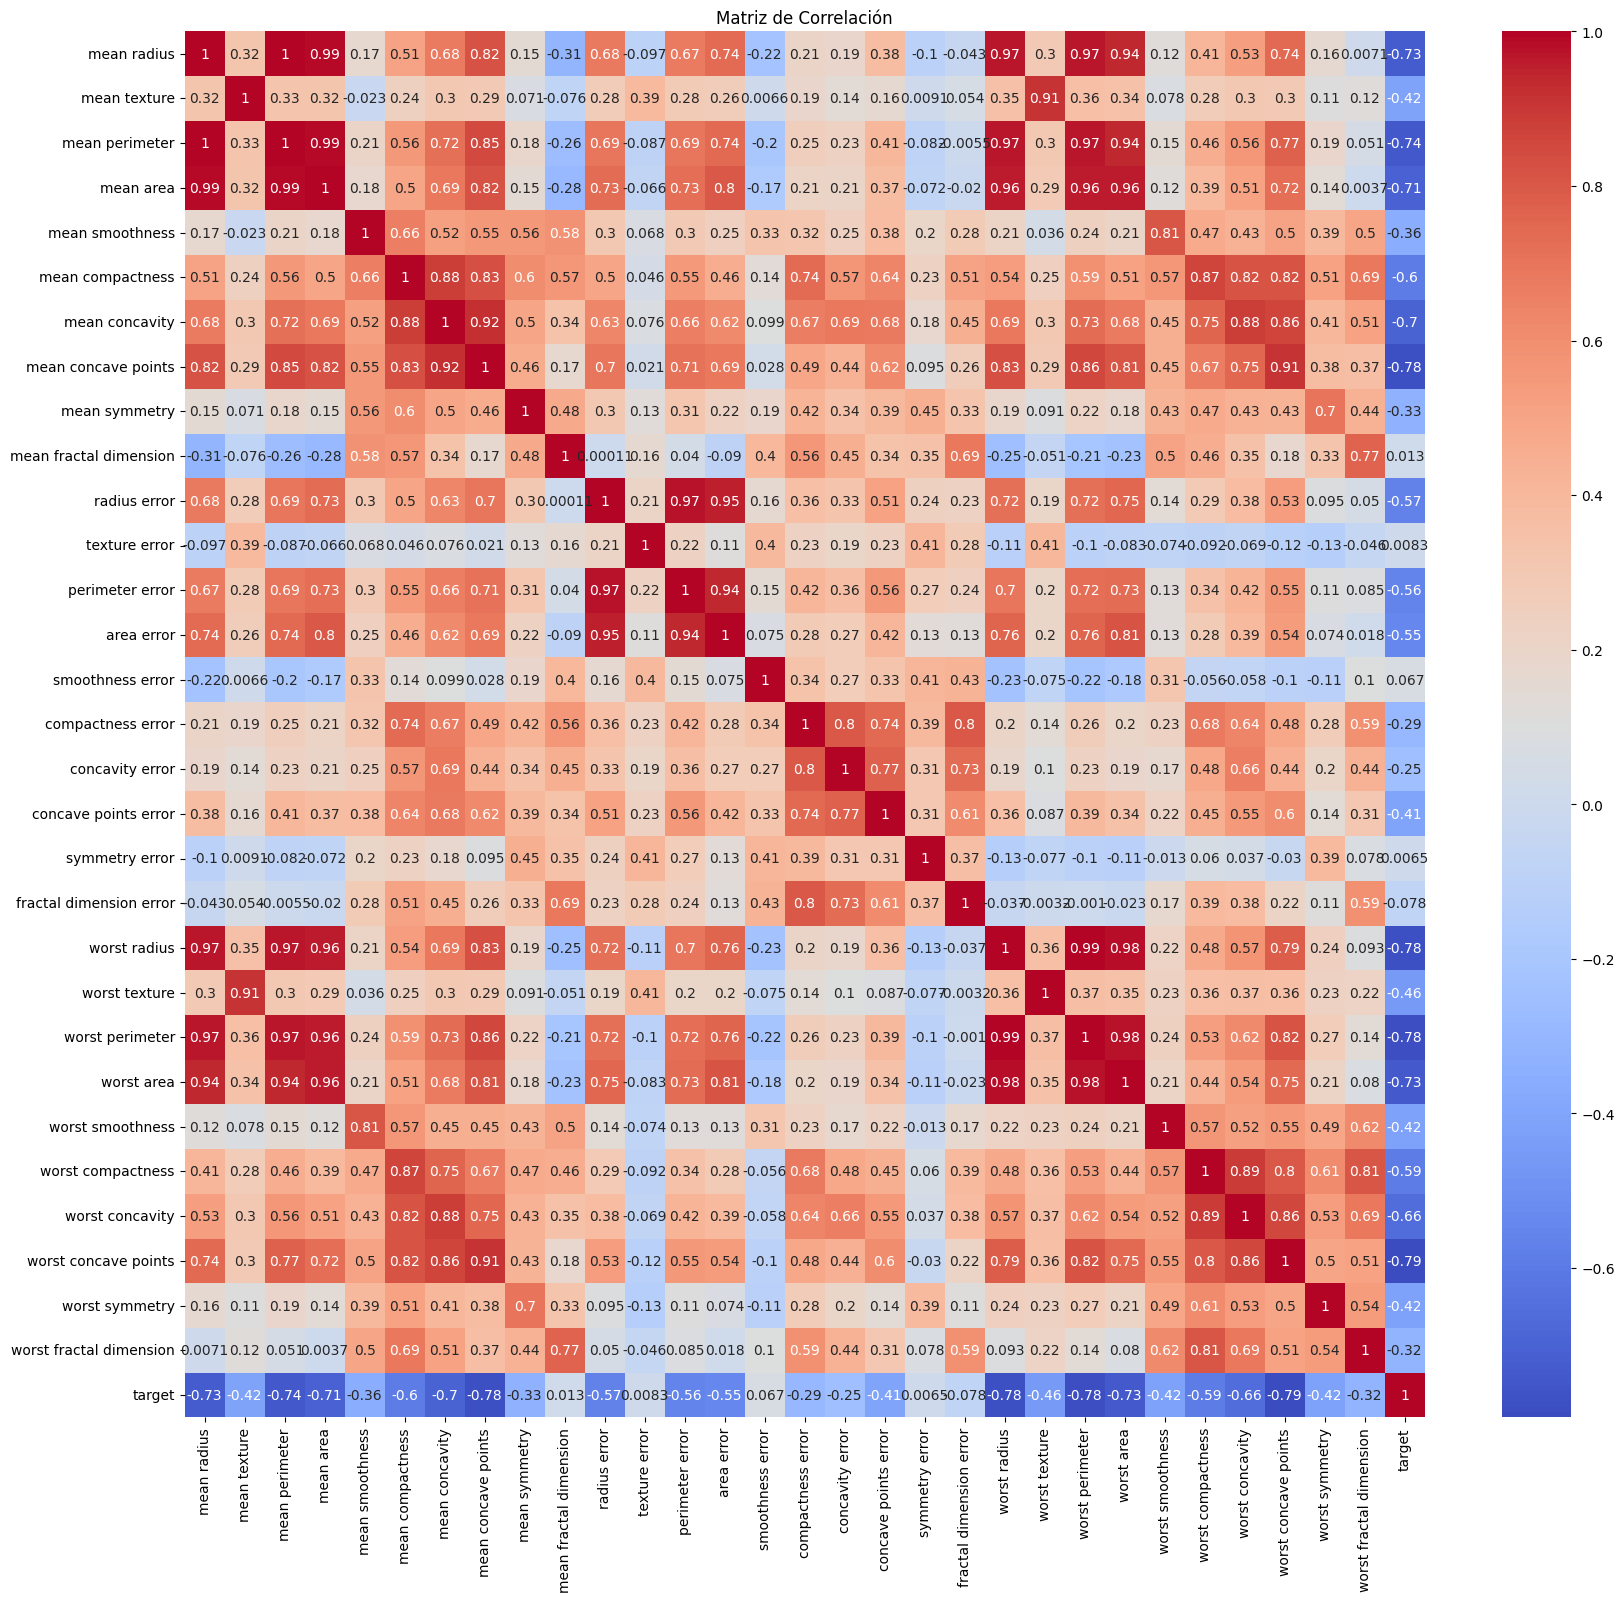

In [ ]:
# Matriz de correlación
correlation_matrix = df.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

##**Relacion variable continua vs categorica**

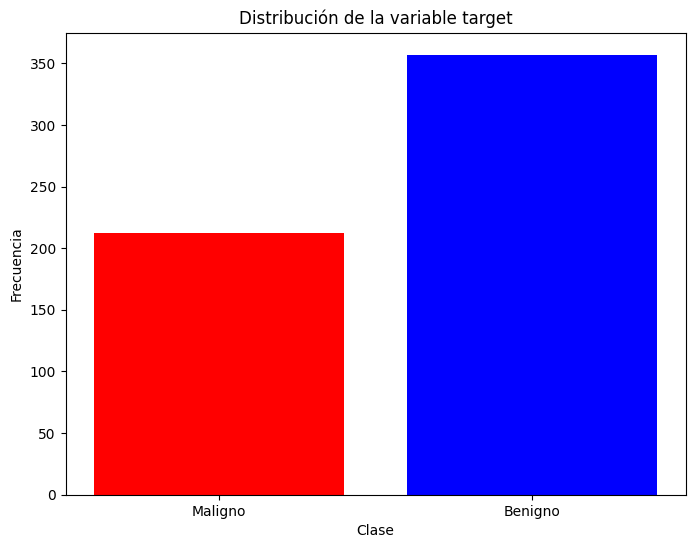

In [ ]:
# Extraemos la columna 'target' del DataFrame y la almacenamos en df_categorico
df_categorico = df['target']

# Obtenemos los conteos de cada valor (0 y 1), los ordenamos por índice (0 antes de 1)
counts = df_categorico.value_counts().sort_index()

# Mappeamos los índices numéricos a etiquetas legibles: 0 → 'Maligno', 1 → 'Benigno'
counts.index = counts.index.map({0: 'Maligno', 1: 'Benigno'})

# Definimos una paleta de colores personalizada:
#   - 0 (Maligno) en rojo, para destacar gravedad
#   - 1 (Benigno) en azul, más calmado
colors = ['red', 'blue']

# Etiquetas que iremos a usar en el eje X del gráfico
labels = ['Maligno', 'Benigno']

# Configuramos el tamaño de la figura para que sea clara y legible
plt.figure(figsize=(8, 6))

# Dibujamos un diagrama de barras con las etiquetas y los conteos, usando nuestros colores
plt.bar(labels, counts, color=colors)

# Título descriptivo del gráfico
plt.title('Distribución de la variable target')

# Etiqueta del eje X (clases)
plt.xlabel('Clase')

# Etiqueta del eje Y (frecuencia de cada clase)
plt.ylabel('Frecuencia')

# Mostramos el gráfico en pantalla
plt.show()


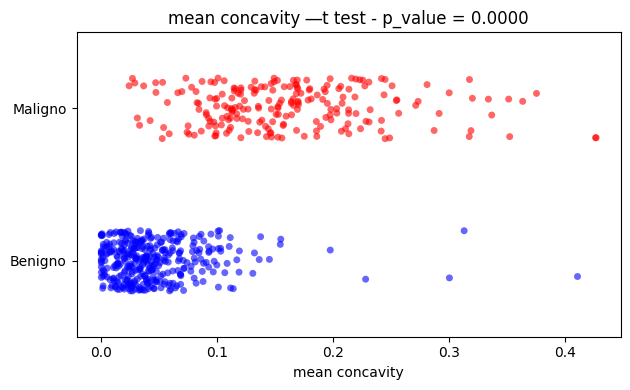

In [ ]:
interactive_ttest_stripplot(df)

In [ ]:
interactive_gaussian_density(df)

Output()

#**Machine learning -Regresion y Clasificacion-**

##**Regresion  lineal**

In [ ]:
visualizador_regresion_lineal_simple(df)

In [ ]:
visualizador_regresion_lineal_MSE(df)

##**Clasificador**

In [ ]:
visualizador_clasificador_univariable(df)

In [ ]:
interactive_multidim_selector(df)

In [ ]:
interactive_3d_scatter_rotatable(df)

In [ ]:
interactive_pairplot(df)

#**Deep Learning - Perceptron y MLP-**

##**Perceptron**

In [ ]:
visualizador_clasificador_multivariable(df)


##**MLP**

In [ ]:
visualizador_clasificador_mlp(df)

Output()